# 決策樹 Decision Tree

## 決策樹的優點

* 易於理解和解釋 人們很容易理解決策樹的意義。
* 只需很少的數據準備 其他技術往往需要數據歸一化。
* 即可以處理數值型數據也可以處理類別型數據。
* 使用白箱模型. 輸出結果容易通過模型的結構來解釋。
* 可以通過測試集來驗證模型的性能。可以考慮模型的穩定性。
* 強健控制. 對噪聲處理有好的強健性。
* 可以很好的處理大規模數據 。


## 決策樹介紹
* feature (特徵欄位)
    * 判斷的資訊
* label (標籤欄位)
    * 預測的目標
    
    
    
* maxBind
    * 每一個節點的最大分支樹
* maxDepth
    * 決策樹的最大深度
* Impurity
    * 分裂節點時的方法

# 過程
1. 蒐集資料、處理資料
2. 訓練模型
3. 使用模型進行預測
4. 評估準確率
5. 探討模型的訓練參數如何影響準確率
6. 找出準確率最高的參數組合
7. 避免過度訓練

[架構流程](https://2.bp.blogspot.com/-CyhOxo3HlHo/Vv4HzQO9kCI/AAAAAAAAGMs/Woc3WMgAAnokFlvHitxsIiGv8kooRgksw/s1600/p12.jpg)

In [ ]:
sc.master

# 1. 資料準備

 資料來源：[www.kaggle.com/c/stumbleupon/data](https://www.kaggle.com/c/stumbleupon/data)

In [1]:
#看看前兩筆資料
rawDataWithHeader = sc.textFile("train.tsv")
rawDataWithHeader.take(2)

['"url"\t"urlid"\t"boilerplate"\t"alchemy_category"\t"alchemy_category_score"\t"avglinksize"\t"commonlinkratio_1"\t"commonlinkratio_2"\t"commonlinkratio_3"\t"commonlinkratio_4"\t"compression_ratio"\t"embed_ratio"\t"framebased"\t"frameTagRatio"\t"hasDomainLink"\t"html_ratio"\t"image_ratio"\t"is_news"\t"lengthyLinkDomain"\t"linkwordscore"\t"news_front_page"\t"non_markup_alphanum_characters"\t"numberOfLinks"\t"numwords_in_url"\t"parametrizedLinkRatio"\t"spelling_errors_ratio"\t"label"',
 '"http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-by-2015.html"\t"4042"\t"{""title"":""IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries"",""body"":""A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the S

In [2]:
#開始整理資料
header = rawDataWithHeader.first() 
rawData = rawDataWithHeader.filter(lambda x:x !=header)    
rData=rawData.map(lambda x: x.replace("\"", ""))    
lines = rData.map(lambda x: x.split("\t"))
print("共計：" + str(lines.count()) + "筆")

共計：7395筆


In [3]:
lines.first()[3:]

['business',
 '0.789131',
 '2.055555556',
 '0.676470588',
 '0.205882353',
 '0.047058824',
 '0.023529412',
 '0.443783175',
 '0',
 '0',
 '0.09077381',
 '0',
 '0.245831182',
 '0.003883495',
 '1',
 '1',
 '24',
 '0',
 '5424',
 '170',
 '8',
 '0.152941176',
 '0.079129575',
 '0']

In [4]:
categoriesMap =lines.map(lambda fields: fields[3]).distinct().zipWithIndex().collectAsMap()

In [5]:
categoriesMap

{'?': 2,
 'arts_entertainment': 0,
 'business': 6,
 'computer_internet': 1,
 'culture_politics': 10,
 'gaming': 7,
 'health': 13,
 'law_crime': 8,
 'recreation': 12,
 'religion': 4,
 'science_technology': 11,
 'sports': 9,
 'unknown': 5,
 'weather': 3}

In [ ]:
len(categoriesMap)

In [ ]:
type(categoriesMap)

In [6]:
import numpy as np
def extract_features(field,categoriesMap,featureEnd):
    #擷取分類特徵欄位
    categoryIdx = categoriesMap[field[3]] 
    categoryFeatures = np.zeros(len(categoriesMap))
    categoryFeatures[categoryIdx] = 1
    #擷取數值欄位
    numericalFeatures=[convert_float(field)  for  field in field[4: featureEnd]]    
    #回傳「分類特徵欄位」+「數字特徵欄位」
    return  np.concatenate(( categoryFeatures, numericalFeatures))

def convert_float(x):
    return (0 if x=="?" else float(x))

In [7]:
def extract_label(field):
    label=(field[-1])
    return float(label)

In [8]:
#建一個labelRDD
labelRDD = lines.map( lambda r: extract_label(r))
print(labelRDD.take(10))

[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]


In [9]:

from pyspark.mllib.regression import LabeledPoint
labelpointRDD = lines.map( lambda r: 
     LabeledPoint(
                extract_label(r),
                extract_features(r,categoriesMap,len(r) - 1)))

In [10]:
print(lines.first()[3:])

['business', '0.789131', '2.055555556', '0.676470588', '0.205882353', '0.047058824', '0.023529412', '0.443783175', '0', '0', '0.09077381', '0', '0.245831182', '0.003883495', '1', '1', '24', '0', '5424', '170', '8', '0.152941176', '0.079129575', '0']


In [11]:
labelpointRDD.take(1)

[LabeledPoint(0.0, [0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.789131,2.055555556,0.676470588,0.205882353,0.047058824,0.023529412,0.443783175,0.0,0.0,0.09077381,0.0,0.245831182,0.003883495,1.0,1.0,24.0,0.0,5424.0,170.0,8.0,0.152941176,0.079129575])]

In [ ]:
#將DATA分成trainData, validationData, testData
(trainData, validationData, testData) = g.randomSplit([8, 1, 1])
print("將資料分trainData:" + str(trainData.count()) +   
          "   validationData:" + str(validationData.count()) + 
          "   testData:" + str(testData.count()))


In [ ]:
#總整

In [12]:
def PrepareData(sc): 
    #----------------------1.匯入並轉換資料-------------
#    global Path    
#    if sc.master[0:5]=="local" :
#       Path="file:/home/hduser/pythonsparkexample/PythonProject/"
#    else:   
#       Path="hdfs://master:9000/user/hduser/"

    print("開始匯入資料...")
    rawDataWithHeader = sc.textFile("train.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共計：" + str(lines.count()) + "筆")
    #----------2.建立訓練評估所需資料 RDD[LabeledPoint]-------    
    categoriesMap = lines.map(lambda fields: fields[3]).\
                                   distinct().zipWithIndex().collectAsMap()
    labelpointRDD = lines.map( lambda r:
               LabeledPoint(
                      extract_label(r), 
                      extract_features(r,categoriesMap,-1)))
    
#    labelpointRDDFeaturesInfo = lines.map( lambda r:LabeledPoint(
#                 extract_label(r), 
#                 extract_features_FeaturesInfo(r,categoriesMap,len(r) - 1))
    #-----------3.以隨機方式將資料分為3部份並且回傳-------------
    (trainData, validationData, testData) = labelpointRDD.randomSplit([8, 1, 1])
    print("將資料分trainData:" + str(trainData.count()) + 
              "   validationData:" + str(validationData.count()) +
              "   testData:" + str(testData.count()))
    return (trainData, validationData, testData, categoriesMap) #回傳資料


In [13]:
(trainData, validationData, testData, categoriesMap) =PrepareData(sc)

開始匯入資料...
共計：7395筆
將資料分trainData:5936   validationData:748   testData:711


In [14]:
trainData.persist()
validationData.persist()
testData.persist()

PythonRDD[30] at RDD at PythonRDD.scala:48

# 2.	訓練模型

In [15]:
from pyspark.mllib.tree import DecisionTree
model=DecisionTree.trainClassifier( \
        trainData, numClasses=2, categoricalFeaturesInfo={}, \
        impurity="entropy", maxDepth=5, maxBins=5)

In [16]:
model

DecisionTreeModel classifier of depth 5 with 61 nodes

In [22]:
print(model.toDebugString())

DecisionTreeModel classifier of depth 5 with 61 nodes
  If (feature 31 <= 1242.0)
   If (feature 0 <= 0.0)
    If (feature 23 <= 0.038433112)
     If (feature 9 <= 0.0)
      If (feature 15 <= 1.920199501)
       Predict: 0.0
      Else (feature 15 > 1.920199501)
       Predict: 1.0
     Else (feature 9 > 0.0)
      If (feature 33 <= 5.0)
       Predict: 0.0
      Else (feature 33 > 5.0)
       Predict: 0.0
    Else (feature 23 > 0.038433112)
     If (feature 13 <= 0.0)
      If (feature 15 <= 1.920199501)
       Predict: 0.0
      Else (feature 15 > 1.920199501)
       Predict: 0.0
     Else (feature 13 > 0.0)
      If (feature 23 <= 0.080831409)
       Predict: 1.0
      Else (feature 23 > 0.080831409)
       Predict: 0.0
   Else (feature 0 > 0.0)
    If (feature 34 <= 0.284294235)
     If (feature 29 <= 20.0)
      If (feature 26 <= 0.123595506)
       Predict: 0.0
      Else (feature 26 > 0.123595506)
       Predict: 0.0
     Else (feature 29 > 20.0)
      If (feature 14 <= 0.75451

# 3.	使用模型進行預測

In [23]:
def PredictData(sc,model,categoriesMap): 
    print("開始匯入資料...")
    rawDataWithHeader = sc.textFile("test.tsv")
    header = rawDataWithHeader.first() 
    rawData = rawDataWithHeader.filter(lambda x:x !=header)    
    rData=rawData.map(lambda x: x.replace("\"", ""))    
    lines = rData.map(lambda x: x.split("\t"))
    print("共計：" + str(lines.count()) + "筆")
    dataRDD = lines.map(lambda r:  ( r[0]  ,
                            extract_features(r,categoriesMap,len(r) )))
    DescDict = {
           0: "暫時性網頁(ephemeral)",
           1: "長青網頁(evergreen)"
     }
    for data in dataRDD.take(10):
        predictResult = model.predict(data[1])
        print (" 網址：  " +str(data[0])+"\n" + "==>預測:"+ str(predictResult)+ " 說明:"+DescDict[predictResult] +"\n")
    

In [24]:
print("==========預測資料===============")
PredictData(sc, model, categoriesMap)

==========預測資料===============
開始匯入資料...
共計：3171筆
 網址：  http://www.lynnskitchenadventures.com/2009/04/homemade-enchilada-sauce.html
==>預測:1.0 說明:長青網頁(evergreen)

 網址：  http://lolpics.se/18552-stun-grenade-ar
==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.xcelerationfitness.com/treadmills.html
==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.bloomberg.com/news/2012-02-06/syria-s-assad-deploys-tactics-of-father-to-crush-revolt-threatening-reign.html
==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.wired.com/gadgetlab/2011/12/stem-turns-lemons-and-limes-into-juicy-atomizers/
==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.latimes.com/health/boostershots/la-heb-fat-tax-denmark-20111013,0,2603132.story
==>預測:0.0 說明:暫時性網頁(ephemeral)

 網址：  http://www.howlifeworks.com/a/a?AG_ID=1186&cid=7340ci
==>預測:1.0 說明:長青網頁(evergreen)

 網址：  http://romancingthestoveblog.wordpress.com/2010/01/13/sweet-potato-ravioli-with-lemon-sage-brown-butter-sauce/
==>預測:1.0 說明:長青網頁(evergreen)

 網址：  http://www.funniez.ne

# 4.	評估模型的準確率

### AUC

                        |acture
                        |positves      |negatives
    ____________________|______________|__________
    predict |positives  |TP            |FP
            |negatives  |FN            |TN
            
    TPR：所有實際為positives的樣本中，被正確判斷出的比率。
    FPR：所有實際為negatives的樣本中，被誤判positives的比率。
    TPR= TP / (TP + FN)
    FPR= FP / (FP + TN)

AUC 就是用TPR、FRP 畫出的 [ROC](https://zh.wikipedia.org/wiki/ROC%E6%9B%B2%E7%BA%BF) 曲線下的面積
    


In [25]:
score = model.predict(validationData.map(lambda p: p.features))
scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
scoreAndLabels.take(15)

[(1.0, 1.0),
 (0.0, 0.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 1.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (0.0, 1.0),
 (0.0, 0.0)]

In [26]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
metrics = BinaryClassificationMetrics(scoreAndLabels)
print ("AUC="+str(metrics.areaUnderROC))

AUC=0.6600829519450802


In [27]:
def evaluateModel(model, validationData):
    score = model.predict(validationData.map(lambda p: p.features))
    scoreAndLabels=score.zip(validationData.map(lambda p: p.label))
    metrics = BinaryClassificationMetrics(scoreAndLabels)
    AUC=metrics.areaUnderROC
    return( AUC)

In [28]:
AUC=evaluateModel(model, validationData)
print ("AUC="+str(AUC))

AUC=0.6600829519450802


In [29]:
from time import time
def trainEvaluateModel(trainData,validationData,
                                        impurityParm, maxDepthParm, maxBinsParm):
    startTime = time()
    model = DecisionTree.trainClassifier(trainData,
                numClasses=2, categoricalFeaturesInfo={}, impurity=impurityParm,
                maxDepth=maxDepthParm, maxBins=maxBinsParm)
    AUC = evaluateModel(model, validationData)
    duration = time() - startTime
    print ("訓練評估：使用參數" + \
                " impurity="+str(impurityParm) +\
                " maxDepth="+str(maxDepthParm) + \
                " maxBins="+str(maxBinsParm) +"\n" +\
                 " ==>所需時間="+str(duration) + \
                 " 結果AUC = " + str(AUC)) 
    return (AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)

In [30]:
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, validationData, "entropy", 5, 5)

訓練評估：使用參數 impurity=entropy maxDepth=5 maxBins=5
 ==>所需時間=9.28663969039917 結果AUC = 0.6600829519450802


In [31]:
#調節後...再測試
(AUC,duration, impurityParm, maxDepthParm, maxBinsParm,model)=  \
       trainEvaluateModel(trainData, testData, "entropy", 5, 5)

訓練評估：使用參數 impurity=entropy maxDepth=5 maxBins=5
 ==>所需時間=10.05135178565979 結果AUC = 0.6763913112414777


# 5.	模型的訓練參數如何影響準確率?

In [32]:
impurityList=["gini", "entropy"]
maxDepthList  =[10]
maxBinsList=[10]

metrics = [trainEvaluateModel(trainData, validationData,  
                              impurity,maxDepth,  maxBins  ) 
                 for impurity in impurityList 
                 for maxDepth in maxDepthList  
                 for maxBins in maxBinsList ]

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=9.085190773010254 結果AUC = 0.6402602974828375
訓練評估：使用參數 impurity=entropy maxDepth=10 maxBins=10
 ==>所需時間=8.568930387496948 結果AUC = 0.6483695652173913


In [33]:
metrics

[(0.6402602974828375,
  9.085190773010254,
  'gini',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 719 nodes),
 (0.6483695652173913,
  8.568930387496948,
  'entropy',
  10,
  10,
  DecisionTreeModel classifier of depth 10 with 611 nodes)]

In [34]:
import pandas as pd
IndexList=impurityList
df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
df

,AUC,duration,impurity,maxDepth,maxBins,model
gini,0.64026,9.085191,gini,10,10,DecisionTreeModel classifier of depth 10 with ...
entropy,0.64837,8.568930,entropy,10,10,DecisionTreeModel classifier of depth 10 with ...


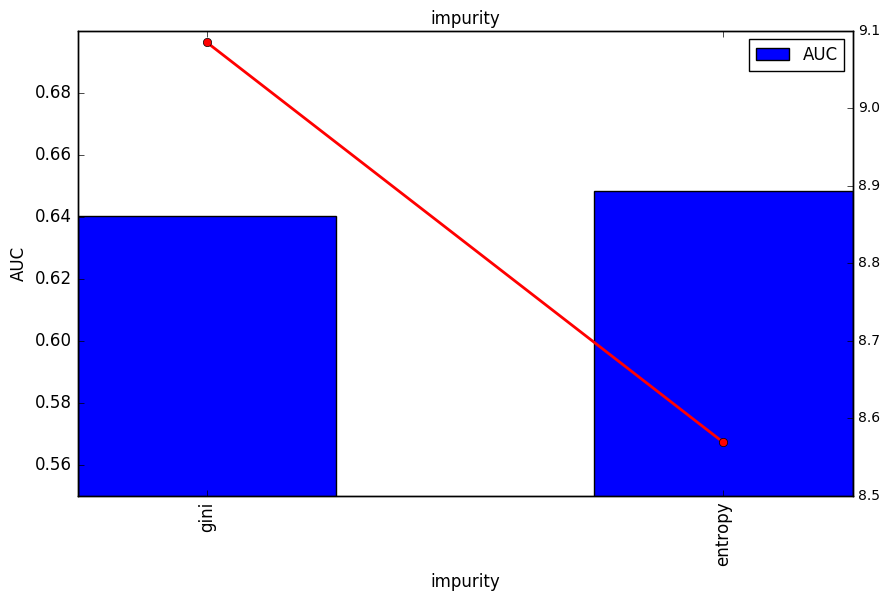

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline 
evalparm='impurity'
ax = df['AUC'].plot(kind='bar', title =evalparm,figsize=(10,6),
                legend=True, fontsize=12)
ax.set_xlabel(evalparm,fontsize=12)
ax.set_ylim([0.55,0.7])
ax.set_ylabel("AUC",fontsize=12)
ax2 = ax.twinx()
ax2.plot(df['duration'].values, linestyle='-', marker='o', linewidth=2.0,color='r')
plt.show()

In [36]:
import matplotlib.pyplot as plt
def showchart(df,evalparm ,barData,lineData,yMin,yMax):
    ax = df[barData].plot(kind='bar', title =evalparm,
                                         figsize=(10,6),legend=True, fontsize=12)
    ax.set_xlabel(evalparm,fontsize=12)
    ax.set_ylim([yMin,yMax])
    ax.set_ylabel(barData,fontsize=12)
    ax2 = ax.twinx()
    ax2.plot(df[lineData ].values, linestyle='-', marker='o',
                    linewidth=2.0,color='r')
    plt.show()

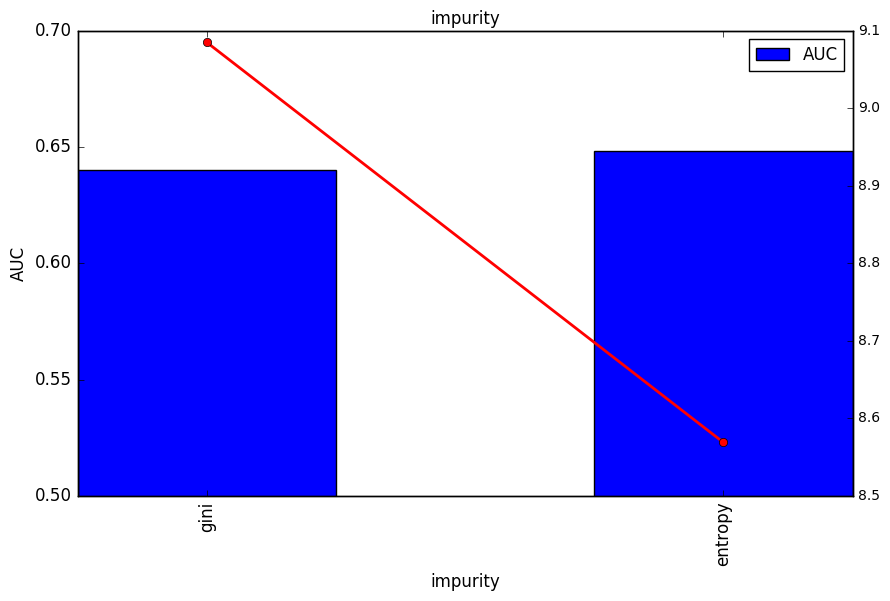

In [37]:
showchart(df,'impurity','AUC','duration',0.5,0.7 )

In [38]:
#定義evalParameter函數
def evalParameter(trainData, validationData, evalparm,
                  impurityList, maxDepthList, maxBinsList):
    #訓練評估參數
    metrics = [trainEvaluateModel(trainData, validationData,  
                                impurity,maxDepth,  maxBins  ) 
                       for impurity in impurityList
                       for maxDepth in maxDepthList  
                       for maxBins in maxBinsList ]
    #設定目前評估的參數
    if evalparm=="impurity":
        IndexList=impurityList[:]
    elif evalparm=="maxDepth":
        IndexList=maxDepthList[:]
    elif evalparm=="maxBins":
        IndexList=maxBinsList[:]
    #轉換為Pandas DataFrame
    df = pd.DataFrame(metrics,index=IndexList,
            columns=['AUC', 'duration','impurity', 'maxDepth', 'maxBins','model'])
    #顯示圖形
    showchart(df,evalparm,'AUC','duration',0.5,0.7 )
    

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=9.183338403701782 結果AUC = 0.6402602974828375
訓練評估：使用參數 impurity=entropy maxDepth=10 maxBins=10
 ==>所需時間=8.33205270767212 結果AUC = 0.6483695652173913


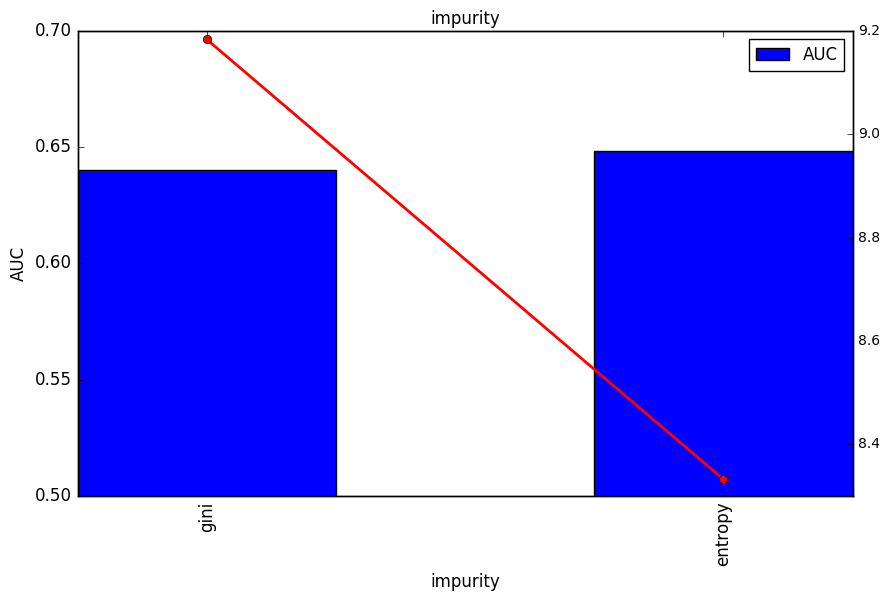

In [39]:
evalParameter(trainData, validationData,"impurity", 
                              impurityList=["gini", "entropy"],   
                              maxDepthList=[10],  
                              maxBinsList=[10])  

訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=10
 ==>所需時間=8.584997653961182 結果AUC = 0.6073512585812356
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=10
 ==>所需時間=8.045238256454468 結果AUC = 0.6459954233409612
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=8.286375522613525 結果AUC = 0.6402602974828375
訓練評估：使用參數 impurity=gini maxDepth=15 maxBins=10
 ==>所需時間=9.178983926773071 結果AUC = 0.6248140732265447
訓練評估：使用參數 impurity=gini maxDepth=20 maxBins=10
 ==>所需時間=9.09569787979126 結果AUC = 0.6111413043478261
訓練評估：使用參數 impurity=gini maxDepth=25 maxBins=10
 ==>所需時間=9.491863489151001 結果AUC = 0.6084668192219679


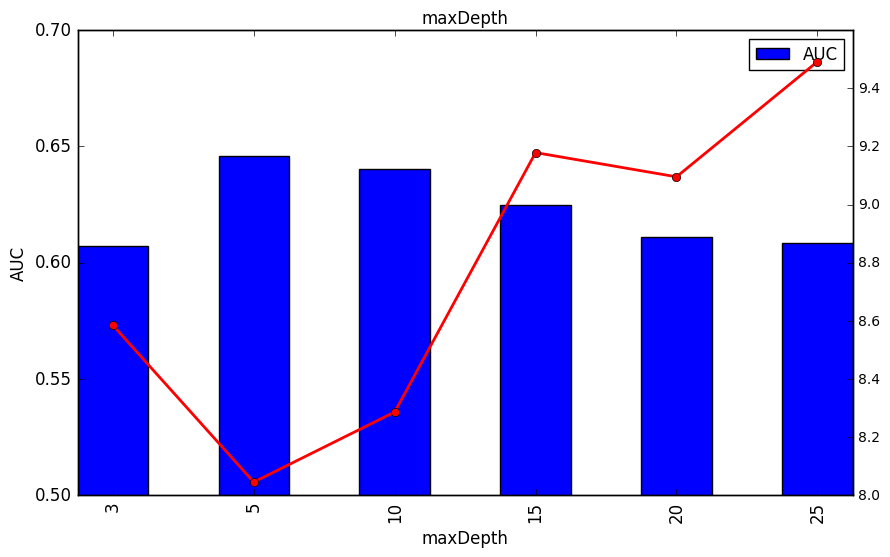

In [40]:
evalParameter(trainData, validationData,"maxDepth", 
                          impurityList=["gini"],                    
                          maxDepthList=[3, 5, 10, 15, 20, 25],    
                          maxBinsList=[10])   

訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=3
 ==>所需時間=8.153414487838745 結果AUC = 0.6093678489702516
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=5
 ==>所需時間=8.233123540878296 結果AUC = 0.6302917620137299
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=8.06782865524292 結果AUC = 0.6402602974828375
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=50
 ==>所需時間=8.141928911209106 結果AUC = 0.6635297482837528
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=100
 ==>所需時間=8.296696662902832 結果AUC = 0.6304204805491991
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=200
 ==>所需時間=9.257473945617676 結果AUC = 0.6240560640732264


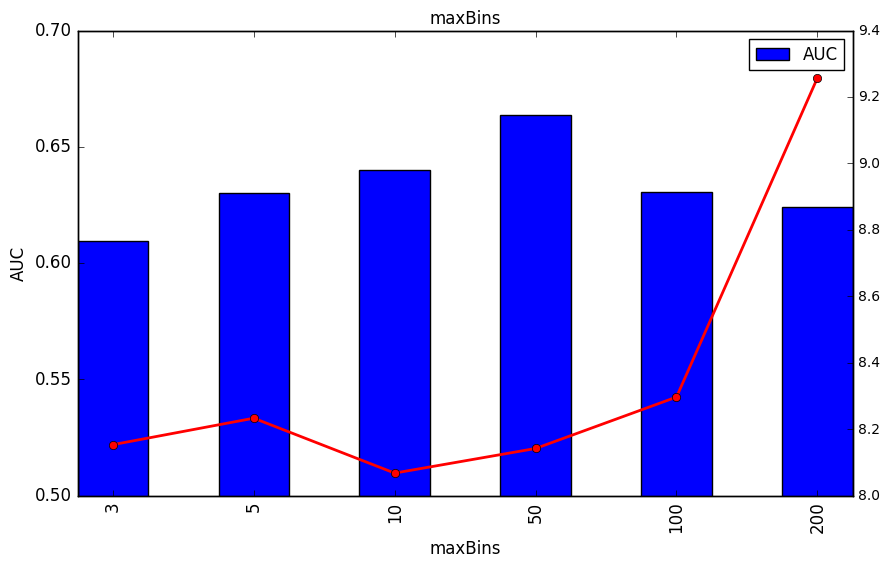

In [41]:
evalParameter(trainData, validationData,"maxBins", 
                          impurityList=["gini"],      
                          maxDepthList =[10],        
                          maxBinsList=[3, 5, 10, 50, 100, 200 ])

# 6.	找出準確率最高的參數組合

In [42]:
#定義evalAllParameter函數
def evalAllParameter(trainData, validationData, 
                     impurityList, maxDepthList, maxBinsList):    
    #for迴圈訓練評估所有參數組合
    metrics = [trainEvaluateModel(trainData, validationData,  
                            impurity,maxDepth,  maxBins  ) 
                      for impurity in impurityList 
                      for maxDepth in maxDepthList  
                      for  maxBins in maxBinsList ]
    #找出AUC最大的參數組合
    Smetrics = sorted(metrics, key=lambda k: k[0], reverse=True)
    bestParameter=Smetrics[0]
    #顯示調校後最佳參數組合      
    print("調校後最佳參數：impurity:" + str(bestParameter[2]) + 
                                      ",maxDepth:" + str(bestParameter[3]) + 
                                     ",maxBins:" + str(bestParameter[4])   + 
                                      "\n,    結果AUC = " + str(bestParameter[0]))
    #傳回最佳模型
    return bestParameter[5]

In [43]:
    print("-----所有參數訓練評估找出最好的參數組合---------")  
    bestModel=evalAllParameter(trainData, validationData,
                          ["gini", "entropy"],
                          [3, 5, 10, 15], 
                          [5, 10, 50, 100])

-----所有參數訓練評估找出最好的參數組合---------
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=5
 ==>所需時間=8.080541610717773 結果AUC = 0.5978975972540046
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=10
 ==>所需時間=8.335002183914185 結果AUC = 0.6073512585812356
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=50
 ==>所需時間=8.00194787979126 結果AUC = 0.6118564073226544
訓練評估：使用參數 impurity=gini maxDepth=3 maxBins=100
 ==>所需時間=7.748267889022827 結果AUC = 0.6062070938215103
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=5
 ==>所需時間=7.7109599113464355 結果AUC = 0.6561784897025171
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=10
 ==>所需時間=7.931723117828369 結果AUC = 0.6459954233409612
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=50
 ==>所需時間=8.527250528335571 結果AUC = 0.6424771167048055
訓練評估：使用參數 impurity=gini maxDepth=5 maxBins=100
 ==>所需時間=7.998324871063232 結果AUC = 0.638229405034325
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=5
 ==>所需時間=8.099339723587036 結果AUC = 0.6302917620137299
訓練評估：使用參數 impurity=gini maxDepth=10 maxBins=10
 ==>所需時間=7.95616412162

# 7. 確認是否Overfitting（過度訓練）

In [ ]:
AUC=evaluateModel(model, testData)
print ("AUC="+str(AUC))